# Customer Churn Project — Part 4: Random Forest and XGBoost

This notebook advances the churn prediction pipeline by applying ensemble tree-based methods — Random Forest and XGBoost — to capture complex behavioral patterns beyond the linear relationships modeled in the logistic regression baseline.

In this notebook, I:
1. Load the processed user-level dataset from the previous step.
2. Train and evaluate Random Forest and XGBoost models to predict churn, optimizing for non-linear interactions and feature importance.
3. Compare performance metrics (ROC-AUC, precision, recall, confusion matrix) against the baseline logistic regression.
4. Use SHAP explainability to interpret global and individual feature effects on churn risk.
5. Simulate actionable business scenarios by adjusting key behavioral variables (e.g., active days, thumbs up) and observing changes in churn probability.

In [15]:
import json
import pandas as pd
import numpy as np
import os
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import pandas as pd

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [16]:
os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/openjdk-17.jdk/Contents/Home"

try:
    spark.stop()
except:
    pass


spark = (
    SparkSession.builder
    .appName("CustomerChurn_EDA")
    .master("local[*]")
    .config("spark.driver.memory", "6g")   # use "8g" if you have ≥16 GB RAM
    .config("spark.sql.shuffle.partitions", "8")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)


ConnectionRefusedError: [Errno 61] Connection refused

In [7]:
data = spark.read.parquet("../data/cleaned_churn_data.parquet")

In [8]:
user_features = (
    data.groupBy("userId")
    .agg(
        F.first("churn_flag").alias("churn_flag"),
        F.countDistinct("sessionId").alias("num_sessions"),
        F.sum(F.when(F.col("page") == "NextSong", 1).otherwise(0)).alias("num_songs"),
        F.sum(F.when(F.col("page") == "Thumbs Up", 1).otherwise(0)).alias("thumbs_up"),
        F.sum(F.when(F.col("page") == "Thumbs Down", 1).otherwise(0)).alias("thumbs_down"),
        F.sum(F.when(F.col("page") == "Add to Playlist", 1).otherwise(0)).alias("add_playlist"),
        ( (F.max("ts") - F.min("ts")) / (1000 * 60 * 60 * 24) ).alias("active_days")
    )
)

#### **Why Move to Random Forest and XGBoost?**

In the previous notebook [03_Logistic_Regression_Classifier.ipynb](03_Logistic_Regression_Classifier.ipynb), the Logistic Regression model achieved a ROC-AUC of 0.85, showing strong baseline performance and clear interpretability of behavioral drivers. However, as I previously mentioned, there are several factors that indicate the need for more advanced models: limitations due to linearity, disregard of interaction effects, and model bias—which can result in underfitting or overfitting. Additionally, some simulation changes (where I intentionally added more active days) led to immediately observed changes in the outcomes. Considering all these factors suggests that a boosted model can better capture these effects and provide more realistic simulation results.



### I. Random Forest Classifier

In [11]:
feature_cols = [
    "num_sessions",
    "num_songs",
    "thumbs_up",
    "thumbs_down",
    "add_playlist",
    "active_days"
]


assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
rf = RandomForestClassifier(labelCol="churn_flag", featuresCol="features", numTrees=100, maxDepth=8)


rf_pipeline = Pipeline(stages=[assembler, rf])

train_df, test_df = user_features.randomSplit([0.7, 0.3], seed=42)

rf_model = rf_pipeline.fit(train_df)


predictions = rf_model.transform(test_df)
evaluator = BinaryClassificationEvaluator(labelCol="churn_flag", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

print(f"ROC–AUC (Random Forest): {roc_auc:.3f}")

25/10/16 20:09:04 WARN DAGScheduler: Broadcasting large task binary with size 1757.5 KiB
25/10/16 20:09:05 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
25/10/16 20:09:14 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


ROC–AUC (Random Forest): 0.906


/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_1237/3085925747.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rf_importance, x="Importance", y="Feature", palette="crest")


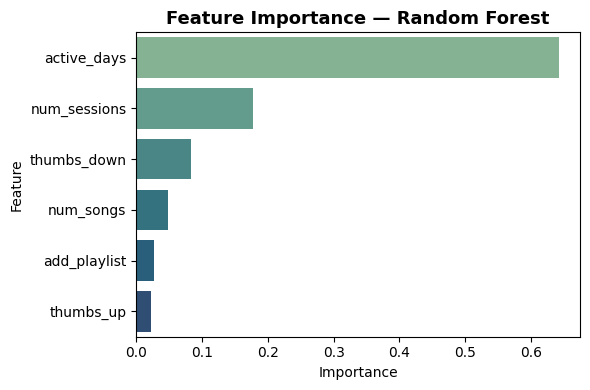

25/10/17 02:12:34 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 939934 ms exceeds timeout 120000 ms
25/10/17 02:12:34 WARN SparkContext: Killing executors is not supported by current scheduler.
25/10/17 02:12:40 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [ ]:
rf_importance = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": rf_model.stages[-1].featureImportances.toArray()
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(data=rf_importance, x="Importance", y="Feature", palette="crest")
plt.title("Feature Importance — Random Forest", fontsize=13, weight="semibold")
plt.tight_layout()
plt.show()

**Performance:**
- ROC–AUC = **0.905**, improving significantly over the logistic baseline (0.841)
- This indicates strong discriminatory power and highly predictive engagement patterns.

**Interpretation:**
- **Active Days** dominates feature importance, showing that consistent platform use is the strongest retention signal.
- **Number of Sessions** and **Thumbs Down** also carry significant weight.
- Positive interactions (adding playlists, thumbs up) contribute to reducing churn, though with lower importance.

**Conclusion:**
The Random Forest model captures complex user behaviors that linear models miss, providing a robust predictive baseline for identifying at-risk customers.

### II. Gradient-Boosted Trees Classifier (PySpark ML)

25/10/15 17:35:04 WARN DAGScheduler: Broadcasting large task binary with size 1002.0 KiB
25/10/15 17:35:04 WARN DAGScheduler: Broadcasting large task binary with size 1006.5 KiB
25/10/15 17:35:04 WARN DAGScheduler: Broadcasting large task binary with size 1009.2 KiB
25/10/15 17:35:04 WARN DAGScheduler: Broadcasting large task binary with size 1009.7 KiB
25/10/15 17:35:04 WARN DAGScheduler: Broadcasting large task binary with size 1010.7 KiB
25/10/15 17:35:04 WARN DAGScheduler: Broadcasting large task binary with size 1011.5 KiB
25/10/15 17:35:04 WARN DAGScheduler: Broadcasting large task binary with size 1013.8 KiB
25/10/15 17:35:04 WARN DAGScheduler: Broadcasting large task binary with size 1018.5 KiB
25/10/15 17:35:04 WARN DAGScheduler: Broadcasting large task binary with size 1021.2 KiB
25/10/15 17:35:04 WARN DAGScheduler: Broadcasting large task binary with size 1021.7 KiB
25/10/15 17:35:04 WARN DAGScheduler: Broadcasting large task binary with size 1022.7 KiB
25/10/15 17:35:04 WAR

ROC–AUC (Gradient-Boosted Trees): 0.903


/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_28415/842445043.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gbt_importance, x="Importance", y="Feature", palette="mako")


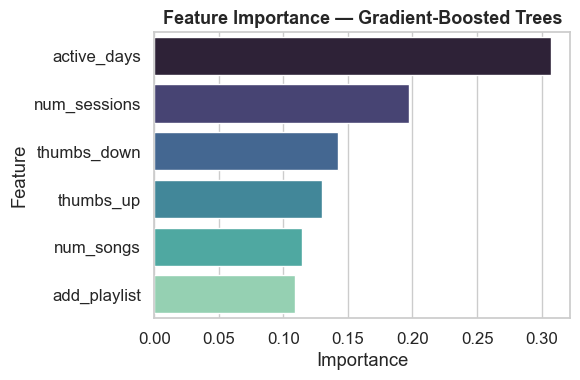

In [11]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assemble features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Initialize GBT
gbt = GBTClassifier(
    labelCol="churn_flag",
    featuresCol="features",
    maxIter=100,      # number of boosting iterations
    maxDepth=6,       # depth of each tree
    stepSize=0.1,     # learning rate
    subsamplingRate=0.8,
    seed=42
)

# Build pipeline
gbt_pipeline = Pipeline(stages=[assembler, gbt])

# Train/test split (reuse same)
train_df, test_df = user_features.randomSplit([0.7, 0.3], seed=42)

# Fit model
gbt_model = gbt_pipeline.fit(train_df)

# Predict and evaluate
predictions = gbt_model.transform(test_df)
evaluator = BinaryClassificationEvaluator(labelCol="churn_flag", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

print(f"ROC–AUC (Gradient-Boosted Trees): {roc_auc:.3f}")

# Feature importance
gbt_importance = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": gbt_model.stages[-1].featureImportances.toArray()
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(data=gbt_importance, x="Importance", y="Feature", palette="mako")
plt.title("Feature Importance — Gradient-Boosted Trees", fontsize=13, weight="semibold")
plt.tight_layout()
plt.show()

In [12]:
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType

# UDF to extract second element from probability vector
extract_prob = F.udf(lambda v: float(v[1]) if v is not None else None, DoubleType())

# Generate churn probability predictions
scored_users = (
    gbt_model.transform(user_features)
    .withColumn("churn_prob", extract_prob(F.col("probability")))
    .select("userId", "churn_prob", "churn_flag")
)

# Sort descending by churn probability
top_risk_users = scored_users.orderBy(F.desc("churn_prob"))

# Show top 10
top_risk_users.show(10, truncate=False)

25/10/15 17:35:33 WARN DAGScheduler: Broadcasting large task binary with size 1280.6 KiB


+-------+------------------+----------+
|userId |churn_prob        |churn_flag|
+-------+------------------+----------+
|1387085|0.992714811134162 |1         |
|1398238|0.9925459267541062|1         |
|1383806|0.9921278393846583|1         |
|1763235|0.9918021924465047|1         |
|1180743|0.9914264217164319|1         |
|1713394|0.990601516014885 |1         |
|1369433|0.9902079931717129|1         |
|1551454|0.9901790498178119|1         |
|1807532|0.9899984948384484|1         |
|1323750|0.9898959221165746|1         |
+-------+------------------+----------+
only showing top 10 rows


In [14]:
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType

# UDF to extract second element from probability vector
extract_prob = F.udf(lambda v: float(v[1]) if v is not None else None, DoubleType())

# Generate churn probability predictions
scored_users = (
    gbt_model.transform(user_features)
    .withColumn("churn_prob", extract_prob(F.col("probability")))
    .select("userId", "churn_prob", "churn_flag")
)

# Define a threshold for users at risk (e.g., churn_prob >= 0.8)
at_risk_threshold = 0.8
users_at_risk = scored_users.filter(F.col("churn_prob") >= at_risk_threshold)
num_users_at_risk = users_at_risk.count()

print(f"Number of users at risk (churn probability ≥ {at_risk_threshold}): {num_users_at_risk}")

25/10/15 17:36:04 WARN DAGScheduler: Broadcasting large task binary with size 1279.0 KiB


Number of users at risk (churn probability ≥ 0.8): 2730


Churn Probability Distribution

25/10/15 17:36:08 WARN DAGScheduler: Broadcasting large task binary with size 1284.1 KiB
25/10/15 17:36:08 WARN DAGScheduler: Broadcasting large task binary with size 1284.2 KiB
25/10/15 17:36:09 WARN DAGScheduler: Broadcasting large task binary with size 1261.0 KiB


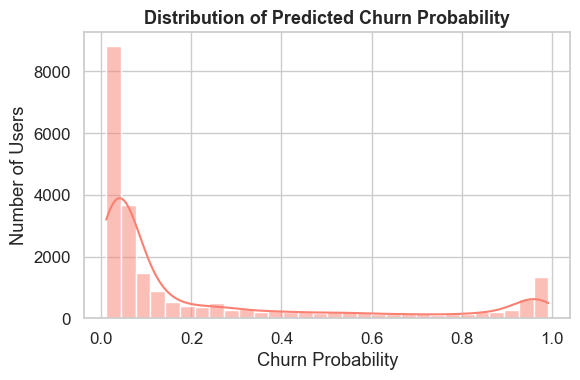

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to pandas for plotting
pdf = top_risk_users.toPandas()

plt.figure(figsize=(6,4))
sns.histplot(pdf['churn_prob'], bins=30, color='salmon', kde=True)
plt.title("Distribution of Predicted Churn Probability", fontsize=13, weight='semibold')
plt.xlabel("Churn Probability")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

Segment Users by Risk

In [16]:
pdf['risk_segment'] = pd.cut(
    pdf['churn_prob'],
    bins=[0, 0.3, 0.7, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)

segment_counts = pdf['risk_segment'].value_counts(normalize=True).mul(100).round(1)
print(segment_counts)

risk_segment
Low Risk       75.7
High Risk      14.0
Medium Risk    10.3
Name: proportion, dtype: float64


/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_28415/4060079157.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='Reds')


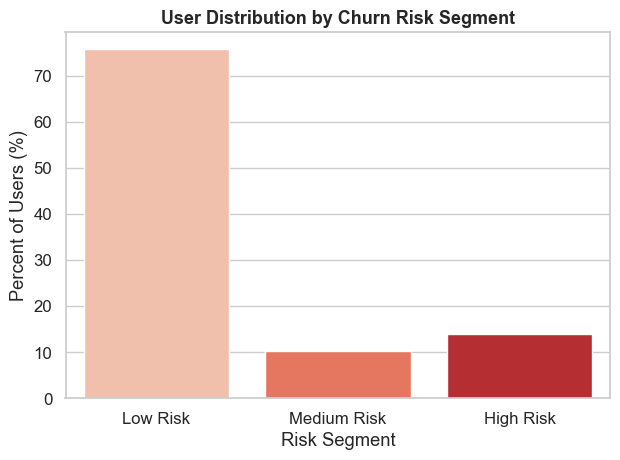

In [17]:
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='Reds')
plt.title("User Distribution by Churn Risk Segment", fontsize=13, weight='semibold')
plt.ylabel("Percent of Users (%)")
plt.xlabel("Risk Segment")
plt.tight_layout()
plt.show()

 Evaluate Model Calibration

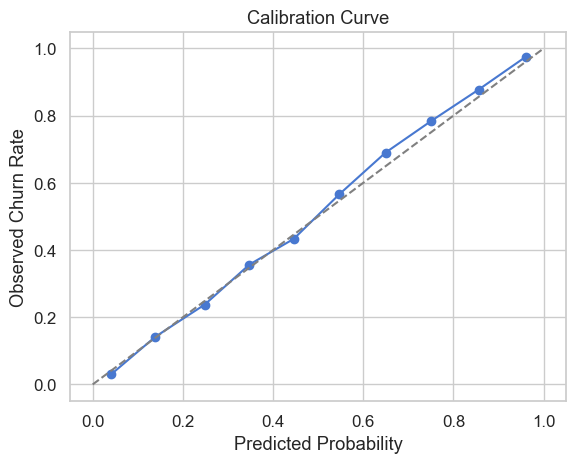

25/10/16 02:43:00 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 924375 ms exceeds timeout 120000 ms
25/10/16 02:43:00 WARN SparkContext: Killing executors is not supported by current scheduler.
25/10/16 02:43:06 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [18]:
from sklearn.calibration import calibration_curve

y_true = pdf['churn_flag']
y_prob = pdf['churn_prob']
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("Calibration Curve")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Churn Rate")
plt.show()

### SHAP

In [19]:
%pip install xgboost shap

  Using cached xgboost-3.0.5-py3-none-macosx_12_0_arm64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.5-py3-none-macosx_12_0_arm64.whl (2.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.6/547.6 kB 18.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 57.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 75.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [shap]5/6 [shap]]t]]
Note: you may need to restart the kernel to use updated packages.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


ROC–AUC (XGBoost): 0.916


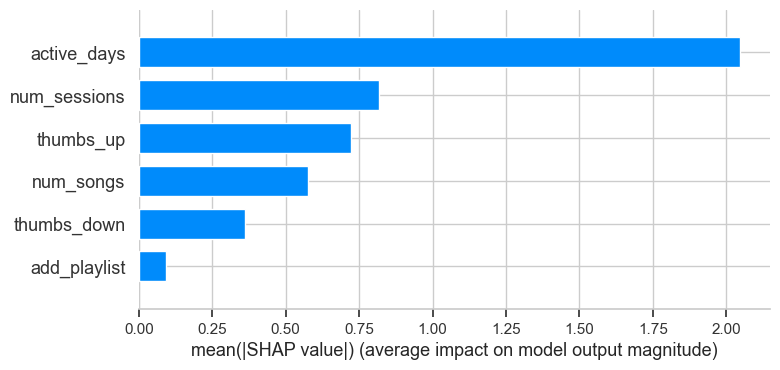

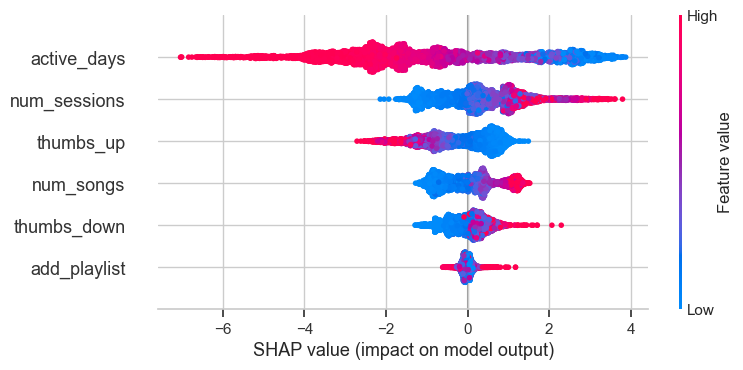

In [21]:
import pandas as pd
from pyspark.sql import functions as F
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import shap
import matplotlib.pyplot as plt

# === Prepare data (re-use your aggregated Spark DF) ===
feature_cols = ["num_sessions", "num_songs", "thumbs_up", "thumbs_down", "add_playlist", "active_days"]

pdf = user_features.select(*feature_cols, "churn_flag").toPandas()
X = pdf[feature_cols].fillna(0)
y = pdf["churn_flag"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# === Train XGBoost (balanced-ish default) ===
pos_weight = (len(y_train) - y_train.sum()) / max(1, y_train.sum())
xgb = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="binary:logistic",
    tree_method="hist",
    scale_pos_weight=pos_weight,
    random_state=42
)
xgb.fit(X_train, y_train)

# Fix: .round() is not a method of float, use Python round() instead
roc_auc = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])
print("ROC–AUC (XGBoost):", round(roc_auc, 3))

# === SHAP global importance ===
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)
shap.summary_plot(shap_values, X_test, show=True)  # beeswarm: direction & magnitude

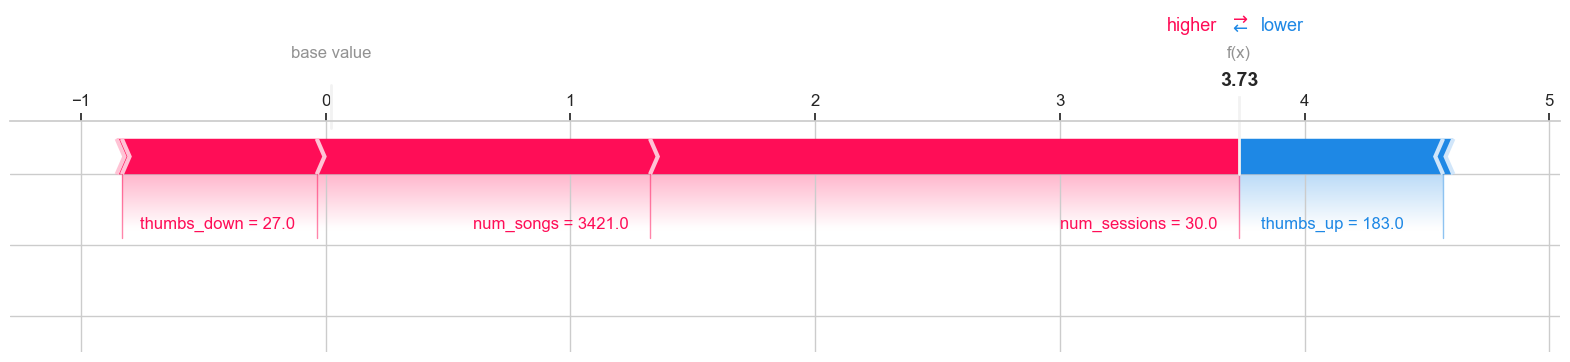

In [22]:
i = 0  # pick a specific user in X_test.index
shap.force_plot(
    explainer.expected_value,
    shap_values[i,:],
    X_test.iloc[i,:],
    matplotlib=True
)
plt.show()

### Retention Simulator (“what if active_days +5?”)

In [23]:
import numpy as np
import pandas as pd

def simulate_intervention(model, X, delta_map, clip_map=None, mask=None):
    """
    model: fitted xgboost (or sklearn) model with predict_proba
    X: pandas DataFrame of features
    delta_map: dict like {"active_days": +5, "thumbs_up": +3}
    clip_map: dict of caps like {"active_days": (0, 60)}
    mask: boolean Series to limit to a cohort (e.g., high risk only)
    """
    X0 = X.copy()
    p0 = model.predict_proba(X0)[:,1]

    X1 = X0.copy()
    for col, delta in delta_map.items():
        X1[col] = X1[col] + delta
    if clip_map:
        for col,(lo,hi) in clip_map.items():
            X1[col] = X1[col].clip(lo, hi)

    if mask is not None:
        X0_ = X0[mask]
        X1_ = X1[mask]
        p0 = model.predict_proba(X0_)[:,1]
        p1 = model.predict_proba(X1_)[:,1]
    else:
        p1 = model.predict_proba(X1)[:,1]

    return {
        "avg_prob_before": float(np.mean(p0)),
        "avg_prob_after":  float(np.mean(p1)),
        "delta_pp":        float((np.mean(p1)-np.mean(p0))*100),  # percentage points
    }

# Example: apply to high-risk users (current prob ≥ 0.7)
p_test = xgb.predict_proba(X_test)[:,1]
high_risk_mask = pd.Series(p_test >= 0.70, index=X_test.index)

result = simulate_intervention(
    model=xgb,
    X=X_test,
    delta_map={"active_days": +5},
    clip_map={"active_days": (0, 60)},
    mask=high_risk_mask
)

print("Retention sim on high-risk users:", result)

Retention sim on high-risk users: {'avg_prob_before': 0.8988791704177856, 'avg_prob_after': 0.7911321520805359, 'delta_pp': -10.774702072143555}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


+-------------------+------------+-------------+-------------------+
|event_month        |active_users|churned_users|churn_rate         |
+-------------------+------------+-------------+-------------------+
|2018-09-01 00:00:00|2050        |21           |0.01024390243902439|
|2018-10-01 00:00:00|21257       |2886         |0.13576704144517102|
|2018-11-01 00:00:00|18512       |2096         |0.1132238547968885 |
+-------------------+------------+-------------+-------------------+



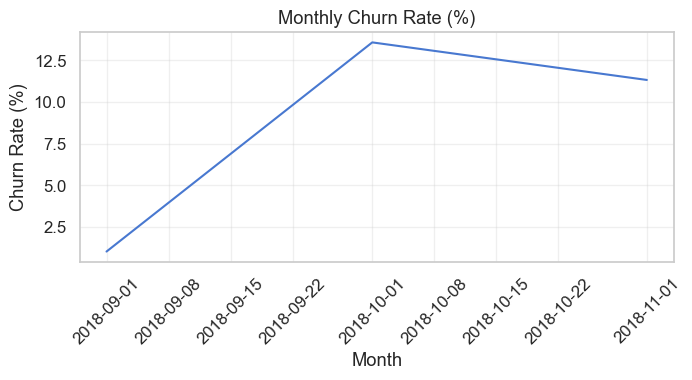

In [28]:
from pyspark.sql import functions as F

# 1) monthly activity: users active in a month
events_month = (
    data
    .withColumn("event_month", F.date_trunc("month", F.from_unixtime(F.col("ts")/1000)))
    .filter(F.col("userId").isNotNull() & (F.col("userId") != ""))
    .select("userId", "event_month")
    .distinct()
    .groupBy("event_month").agg(F.countDistinct("userId").alias("active_users"))
)

# 2) monthly churns: users with Cancellation Confirmation in that month
churn_month = (
    data
    .filter(F.col("page") == "Cancellation Confirmation")
    .withColumn("event_month", F.date_trunc("month", F.from_unixtime(F.col("ts")/1000)))
    .select("userId", "event_month")
    .distinct()
    .groupBy("event_month").agg(F.countDistinct("userId").alias("churned_users"))
)

# 3) join & rate
trend = (
    events_month.join(churn_month, on="event_month", how="left")
    .fillna({"churned_users": 0})
    .withColumn("churn_rate", F.col("churned_users") / F.col("active_users"))
    .orderBy("event_month")
)

trend.show(truncate=False)

# Static plot (to render well on GitHub)
pdf_trend = trend.toPandas()
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(pdf_trend["event_month"], (pdf_trend["churn_rate"]*100))
plt.title("Monthly Churn Rate (%)")
plt.ylabel("Churn Rate (%)")
plt.xlabel("Month")
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
events_month.show()

+-------------------+------------+
|        event_month|active_users|
+-------------------+------------+
|2018-09-01 00:00:00|        2050|
|2018-10-01 00:00:00|       21257|
|2018-11-01 00:00:00|       18512|
+-------------------+------------+



In [ ]:
# SHAP data (optional lightweight export)
pd.DataFrame({"feature": feature_cols, "shap_abs_mean": np.abs(shap_values).mean(axis=0)}).to_csv(
    "../data/shap_global_importance.csv", index=False
)

# Risk list already exported earlier:
# top_risk_users.toPandas().to_csv("../data/at_risk_users.csv", index=False)